Running inference on the test split of a dataset
======================================

If you want to train a PWC-Net model from scratch, or finetune a pre-trained PWC-Net model using your own dataset, you will need to **implement a dataset handler** that derives from the `OpticalFlowDataset` base class in `dataset_base.py`.

Once you have a data handler, you can pass it to a `ModelPWCNet` object and call its  `predict()` method to generate flow predictions for its test split, as demonstrated here.

Below, look for `TODO` references and customize this notebook based on your own needs.

In [1]:
"""
pwcnet_predict.ipynb

Run inference on test split of dataset.

Written by Phil Ferriere

Licensed under the MIT License (see LICENSE for details)
"""
from __future__ import absolute_import, division, print_function
import sys
from copy import deepcopy
from dataset_base import _DEFAULT_DS_TEST_OPTIONS
from dataset_mpisintel import MPISintelDataset
from model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_TEST_OPTIONS
from visualize import display_img_pairs_w_flows

In [2]:
# TODO: You MUST set _DATASET_ROOT to the correct path on your machine!
if sys.platform.startswith("win"):
    _DATASET_ROOT = 'E:/datasets/'
else:
    _DATASET_ROOT = '/media/EDrive/datasets/'
_MPISINTEL_ROOT = _DATASET_ROOT + 'MPI-Sintel'

# TODO: Set device to use for inference
# Here, we're using a GPU (use '/device:CPU:0' to run inference on the CPU)
gpu_devices = ['/device:GPU:0']  
controller = '/device:GPU:0'

# More options...
# Set the number of samples to visually inspect after inference
# Set the path to the trained model (make sure you've downloaded it first from http://bit.ly/tfoptflow)
# Set the batch size
num_samples = 10
ckpt_path = './models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000'
batch_size = 8

In [3]:
# Load the dataset in inference mode, starting with the default options
ds_opts = deepcopy(_DEFAULT_DS_TEST_OPTIONS)
ds_opts['type'] = 'clean'
ds = MPISintelDataset(mode='test', ds_root=_MPISINTEL_ROOT, options=ds_opts)

# Display dataset configuration
ds.print_config()


Dataset Configuration:
  verbose              False
  in_memory            False
  crop_preproc         None
  scale_preproc        None
  type                 clean
  random_seed          1969
  val_split            0.03
  mode                 test
  test size            552


In [4]:
# Configure the model for inference, starting with the default options
nn_opts = deepcopy(_DEFAULT_PWCNET_TEST_OPTIONS)
nn_opts['verbose'] = True
nn_opts['ckpt_path'] = ckpt_path
nn_opts['batch_size'] = batch_size
nn_opts['use_tf_data'] = True
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller

# We're running the PWC-Net-large model in quarter-resolution mode
# That is, with a 6 level pyramid, and upsampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = True
nn_opts['use_res_cx'] = True
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 2

# The size of the images in this dataset are not multiples of 64, while the model generates flows padded to multiples
# of 64. Hence, we need to crop the predicted flows to their original size
nn_opts['adapt_info'] = (1, 436, 1024, 2)

In [5]:
# Instantiate the model in inference mode and display the model configuration
nn = ModelPWCNet(mode='test', options=nn_opts, dataset=ds)
nn.print_config()

Building model...
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
... model built.
Loading model checkpoint ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:GPU:0']
  controller             /device:GPU:0
  batch_size             8
  use_tf_data            True
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           True
  use_res_cx             True
  adapt_

In [6]:
# Generate the predictions and save them directly to disk; no need to return them here
nn.predict(return_preds=False, save_preds=True)

Predicting flows and saving preds: 100%|############################| 69/69 [02:36<00:00,  2.27s/it]


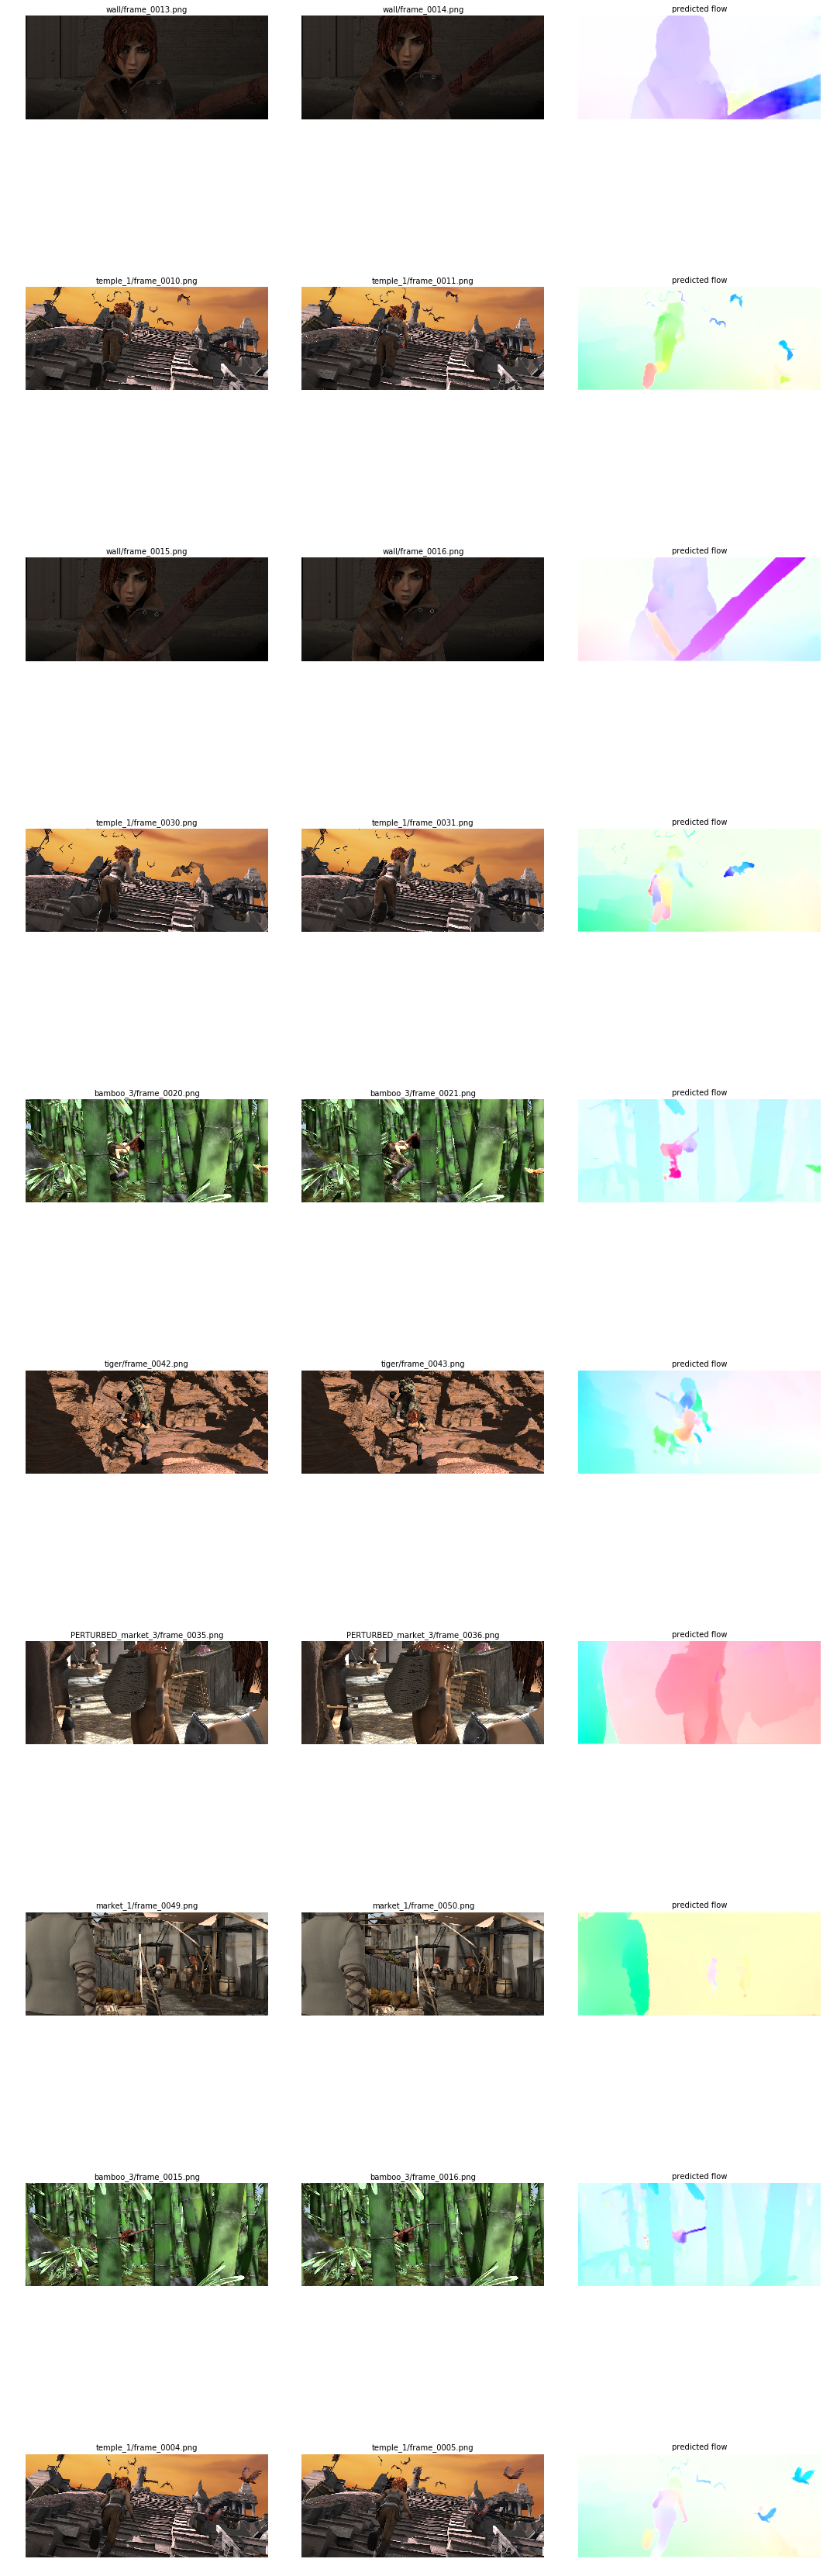

In [7]:
# Display a few random samples and their predictions
img_pairs, pred_labels, ids = ds.get_samples(num_samples, split='test_with_preds', deterministic=False, as_tuple=True)
display_img_pairs_w_flows(img_pairs, pred_labels, titles=ids)